In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [4]:
# Load AutoMPG dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin', 'Make Model']
data = pd.read_csv(url, sep='\s+', names=column_names, na_values="?")

# Drop rows with missing values
data = data.dropna()
data = data.drop("Make Model", axis=1)

In [5]:
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [6]:
# Convert 'Origin' to one-hot encoding
data["Origin"] = data["Origin"].astype(int)
data = pd.get_dummies(data, columns=["Origin"], prefix="Origin")

In [7]:
# Separate features and target
X = data.drop("MPG", axis=1).values
y = data["MPG"].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [8]:
# Define Wave-Encoded Linear Layer
class WaveWeightLinear(nn.Module):
    def __init__(self, in_features, out_features, t_samples=8):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.t = torch.linspace(0, 2 * torch.pi, t_samples)  # Time vector

        # Wave parameters
        self.A = nn.Parameter(torch.randn(in_features, out_features))  # Amplitude
        self.omega = nn.Parameter(torch.rand(in_features, out_features))  # Frequency
        self.phi = nn.Parameter(torch.rand(in_features, out_features) * 2 * torch.pi)  # Phase

    def forward(self, x):
        # Generate waves: (in_features, out_features, t_samples)
        waves = self.A.unsqueeze(-1) * torch.sin(self.omega.unsqueeze(-1) * self.t + self.phi.unsqueeze(-1))

        # Modulate inputs: (batch, in_features, 1) * (1, in_features, out_features, t_samples)
        modulated = x.unsqueeze(-1).unsqueeze(-1) * waves.unsqueeze(0)

        # Sum over inputs and time average: (batch, out_features)
        out = torch.mean(modulated.sum(dim=1), dim=-1)  # Interference + time avg
        return out

# Define Wave-Encoded Neural Network
class WaveNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, t_samples=8):
        super().__init__()
        self.wave_layer1 = WaveWeightLinear(input_size, hidden_size, t_samples)
        self.wave_layer2 = WaveWeightLinear(hidden_size, hidden_size, t_samples)
        self.linear = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.sin(self.wave_layer1(x))
        x = self.relu(self.wave_layer2(x))
        x = self.linear(x)
        return x

In [9]:
# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 128
output_size = 1
learning_rate = 1e-4
num_epochs = 500
t_samples = 8  # Number of time samples for wave encoding

# Initialize model, loss, and optimizer
model = WaveNet(input_size, hidden_size, output_size, t_samples)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    train_preds = model(X_train)
    test_preds = model(X_test)
    train_loss = criterion(train_preds, y_train)
    test_loss = criterion(test_preds, y_test)

print(f"Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

# Example prediction
sample_input = X_test[0].unsqueeze(0)  # Take the first test sample
predicted_mpg = model(sample_input)
print(f"Predicted MPG: {predicted_mpg.item():.2f}, Actual MPG: {y_test[0].item():.2f}")

Epoch [10/500], Loss: 487.4964
Epoch [20/500], Loss: 338.4194
Epoch [30/500], Loss: 203.4720
Epoch [40/500], Loss: 118.6787
Epoch [50/500], Loss: 38.2713
Epoch [60/500], Loss: 13.7287
Epoch [70/500], Loss: 29.4927
Epoch [80/500], Loss: 8.7952
Epoch [90/500], Loss: 25.1192
Epoch [100/500], Loss: 21.2164
Epoch [110/500], Loss: 12.6183
Epoch [120/500], Loss: 8.7399
Epoch [130/500], Loss: 11.1267
Epoch [140/500], Loss: 12.3855
Epoch [150/500], Loss: 8.4492
Epoch [160/500], Loss: 11.1910
Epoch [170/500], Loss: 6.3499
Epoch [180/500], Loss: 8.0361
Epoch [190/500], Loss: 7.2909
Epoch [200/500], Loss: 5.3544
Epoch [210/500], Loss: 15.2431
Epoch [220/500], Loss: 3.1711
Epoch [230/500], Loss: 5.4005
Epoch [240/500], Loss: 10.9913
Epoch [250/500], Loss: 7.9903
Epoch [260/500], Loss: 6.0643
Epoch [270/500], Loss: 4.8041
Epoch [280/500], Loss: 4.1974
Epoch [290/500], Loss: 3.5241
Epoch [300/500], Loss: 14.4511
Epoch [310/500], Loss: 10.7358
Epoch [320/500], Loss: 3.2764
Epoch [330/500], Loss: 4.095

In [10]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [11]:
# Calculate metrics
test_r2 = r2_score(y_test, test_preds)
test_mae = mean_absolute_error(y_test, test_preds)
test_mse = mean_squared_error(y_test, test_preds)

print("Wave Network Performance:")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}")

Wave Network Performance:
Test R²: 0.8945
Test MAE: 1.6779
Test MSE: 5.3836


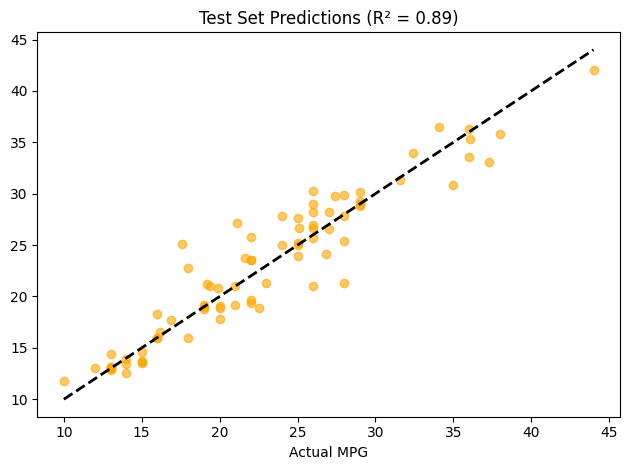

In [12]:
plt.scatter(y_test, test_preds, alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title(f"Test Set Predictions (R² = {test_r2:.2f})")
plt.xlabel("Actual MPG")

plt.tight_layout()
plt.show()

In [13]:
# Convert PyTorch tensors back to numpy arrays for scikit-learn (and log transform to account for skewness)
X_train_np = X_train.numpy()
X_test_np = X_test.numpy()
y_train_np = np.log1p(y_train.numpy())
y_test_np = np.log1p(y_test.numpy())

In [14]:
# Create and train linear regression model
lr = LinearRegression()
lr.fit(X_train_np, y_train_np)

# Make predictions
y_train_pred = np.expm1(lr.predict(X_train_np))
y_test_pred = np.expm1(lr.predict(X_test_np))

y_train_np = np.expm1(y_train_np)
y_test_np = np.expm1(y_test_np)

# Calculate metrics
test_r2 = r2_score(y_test_np, y_test_pred)
test_mae = mean_absolute_error(y_test_np, y_test_pred)
test_mse = mean_squared_error(y_test_np, y_test_pred)

print("Linear Regression Performance:")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}")

Linear Regression Performance:
Test R²: 0.8539
Test MAE: 1.9854
Test MSE: 7.4563


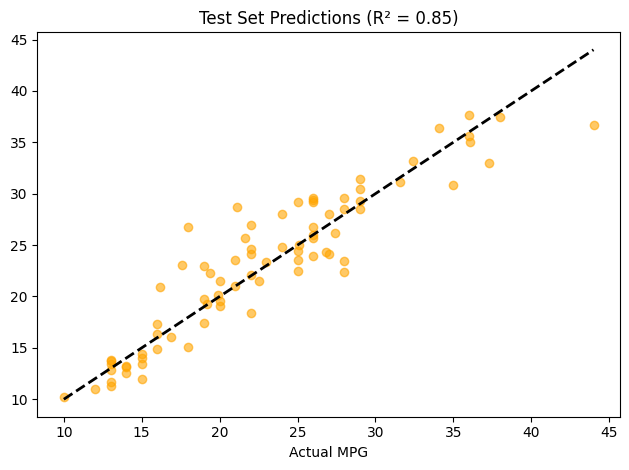

In [15]:
plt.scatter(y_test_np, y_test_pred, alpha=0.6, color='orange')
plt.plot([y_test_np.min(), y_test_np.max()], 
         [y_test_np.min(), y_test_np.max()], 'k--', lw=2)
plt.title(f"Test Set Predictions (R² = {test_r2:.2f})")
plt.xlabel("Actual MPG")

plt.tight_layout()
plt.show()